<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

我完成的：带软间隔（拉格朗日松弛）、核函数、对偶处理后的支持向量机学习算法。

原理方面是根据老师ppt和\[1\]的7.4节，实现的具体细节和优化参考了\[2\]的第六章。

没画图的原因：我们的变量经过整理分类离散化后，每个变量的取值小于等于5，二维图画散点图最多也就5*5个点，其上分布着1400个样本点，大量重合。我尝试绘制了，发现看不出什么规律，效果不好。

整体架构：先用jupyter方便查看每个函数效果是否正确，或者直接写py文件，把确定正确的函数功能封装起来。最后的model不方便调试，只用来查看对比图和变量的，是最后一步展示。


\[1\]	李航, 统计学习方法. 清华大学出版社, 2012.  
\[2\]	P. Harrington, 机器学习实战. 人民邮电出版社, 2013.


In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn import metrics
from numpy import *
import time

import sys
sys.path.append('../smo/')
import smo_simple
import smo_platt_no_kernel
import smo_platt_with_kernel

sys.path.append('../metrics/')
import metrics

plt.rcParams['font.family']=['Songti SC']
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.display.max_rows = 200
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=100, suppress=True)

In [2]:
def test_smo_simple(X,y,df):
    '''简化版的smo'''
    start = time.time()
    y_pred, prob_pre, w, b, alphas, sv_idx, sv_data, sv_label = smo_simple.predict(X,y,max_iter=200)
    end = time.time()
    print(f"time: {end - start} s")
    dff = df.drop(df.columns[[0,1]], axis=1)
    dff.insert(0, 'y_predict', y_pred)
    dff.insert(0, 'y', y)
    dff.insert(0, 'prob_predict', prob_pre)
    recall, precision = metrics.recall_and_precision(dff,metrics.metricStruct(-1,1))
    ks = metrics.plot_ks_curve(dff,metrics.metricStruct(-1,1))
    print(f"recall: {recall}, \nprecision: {precision}, \nks: {ks}")
    
    return recall, precision, ks,end - start#, dff, y_pred, prob_pre, w, b, alphas, sv_idx, sv_data, sv_label

In [4]:
def test_smop_no_kernel(X,y,df):
    '''smo platt版本，用了拉格朗日乘子法做软间隔，没加核函数'''
    start = time.time()
    y_pred, prob_pre, w, b, alphas, sv_idx, sv_data, sv_label = smo_platt_no_kernel.predict(X,y, max_iter=200)
    end = time.time()
    print(f"time: {end - start} s")
    dff = df.drop(df.columns[[0,1]], axis=1)
    dff.insert(0, 'y_predict', y_pred)
    dff.insert(0, 'y', y)
    dff.insert(0, 'prob_predict', prob_pre)
    recall, precision = metrics.recall_and_precision(dff,metrics.metricStruct(-1,1))
    ks = metrics.plot_ks_curve(dff,metrics.metricStruct(-1,1))
    print(f"recall: {recall}, \nprecision: {precision}, \nks: {ks}")

    return recall, precision, ks,end - start#, dff, y_pred, prob_pre, w, b, alphas, sv_idx, sv_data, sv_label

In [3]:
def test_smo_with_kernel(X,y,df,ktype='linear', k1=0, C=0.6, toler=0.0001, max_iter=40):
    '''smo platt版本，用了拉格朗日乘子法做软间隔，加了核函数'''
    start = time.time()
    y_pred, prob_pre, w, b, alphas, sv_idx, sv_data, sv_label = smo_platt_with_kernel.predict(X,y,ktype, k1, C, toler, max_iter)
    end = time.time()
    print(f"time: {end - start} s")
    dff = df.drop(df.columns[[0,1]], axis=1)
    dff.insert(0, 'y_predict', y_pred)
    dff.insert(0, 'y', y)
    dff.insert(0, 'prob_predict', prob_pre)
    recall, precision = metrics.recall_and_precision(dff,metrics.metricStruct(-1,1))
    ks = metrics.plot_ks_curve(dff,metrics.metricStruct(-1,1))
    print(f"recall: {recall}, \nprecision: {precision}, \nks: {ks}")
    
    return recall, precision, ks,end - start#, dff, y_pred, prob_pre, w, b, alphas, sv_idx, sv_data, sv_label

In [24]:
def cmp_score(dict1,type):
    score_df1 = pd.DataFrame(dict1,index=["Recall", "Precision", "KS","Time(s)"])

    # 比较得分
    score_df1.drop(["Time(s)"],axis=0).plot.bar(rot=0)
    t1 = "不同SMO算法的得分" if type==1 else "不同惩罚系数的RBF内核SMO算法得分"
    plt.title(t1)
    plt.ylim(0,1.2)
    plt.ylabel("得分")
    plt.xlabel("指标类别")

    # 比较时间
    score_df1.drop(['Recall','Precision','KS'],axis=0).plot.bar(rot=0)
    t2 = "不同SMO算法的时间(s)" if type==1 else "不同惩罚系数的RBF内核SMO算法的时间(s)"
    plt.title(t2)
    plt.ylabel("时间(s)")
    return score_df1

there are 1217 Support Vectors
time: 41.88054299354553 s


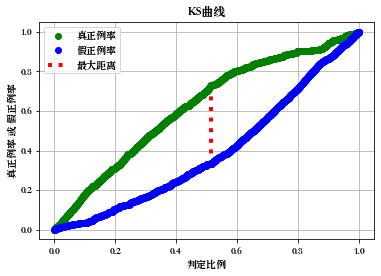

recall: 0.7307692307692307, 
precision: 0.6480218281036835, 
ks: 0.40006056935190787


In [6]:
if __name__ == '__main__':
    df = pd.read_csv("../data/preprocess.csv")
    X,y = df.drop(df.columns[[0,1]], axis=1), df["Label"]
    # X,y = df[["GAGE_TOTLE_PRICE","PAYMENT_TYPE"]], df["Label"]  #选取两个特征方便看图观察
    y = y.apply(lambda x: -1 if x==0 else x)
    t = []
    # t[0]
    t.append(test_smo_simple(X,y,df))

there are 251 Support Vectors
time: 178.39252400398254 s


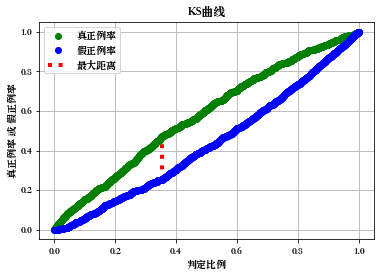

recall: 0.7446153846153846, 
precision: 0.5383759733036707, 
ks: 0.22033918837068445


In [7]:
    # t[1]
    t.append(test_smop_no_kernel(X,y,df))

there are 357 Support Vectors
time: 98.61856889724731 s


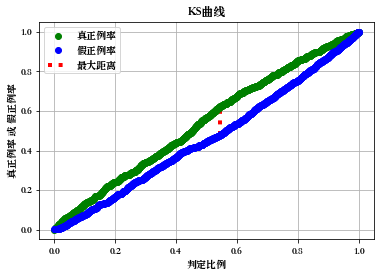

recall: 1.0, 
precision: 0.4603399433427762, 
ks: 0.1484635574399354


In [8]:
    # t[2]
    t.append(test_smo_with_kernel(X,y,df))

there are 126 Support Vectors
time: 140.8271040916443 s


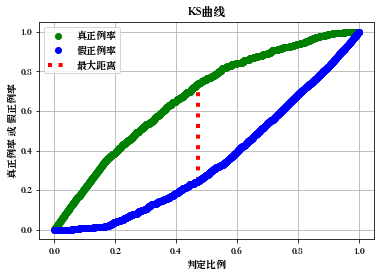

recall: 0.0876923076923077, 
precision: 1.0, 
ks: 0.49613163739148


In [9]:
    # t[3]
    t.append(test_smo_with_kernel(X,y,df,"rbf",1.3,0.6,0.0001,1000))

there are 234 Support Vectors
time: 141.22069096565247 s


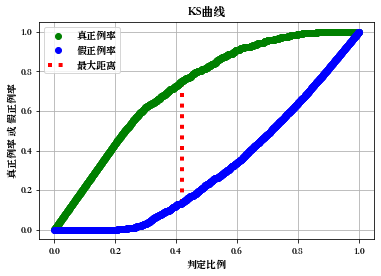

recall: 0.35384615384615387, 
precision: 1.0, 
ks: 0.6184494245911569


In [11]:
    # t[4]
    t.append(test_smo_with_kernel(X,y,df,"rbf",1.3,6,0.0001,1000))

there are 617 Support Vectors
time: 226.5198278427124 s


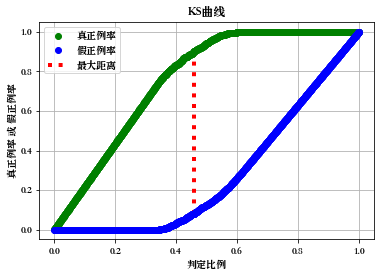

recall: 0.7907692307692308, 
precision: 0.9846743295019157, 
ks: 0.8232505552190591


In [10]:
    # t[5]
    t.append(test_smo_with_kernel(X,y,df,"rbf",1.3,60,0.0001,1000))

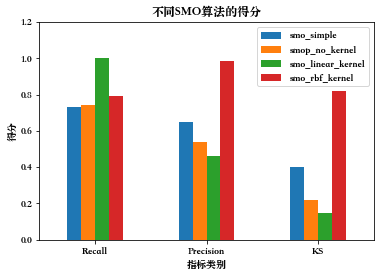

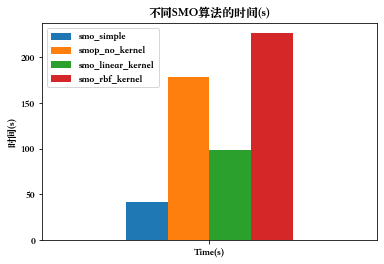

In [27]:
    dict1 = {"smo_simple" : t[0]
         ,"smop_no_kernel" : t[1]
         ,"smo_linear_kernel": t[2]
         ,"smo_rbf_kernel": t[4]
         }
    score_df1 = cmp_score(dict1, 1)

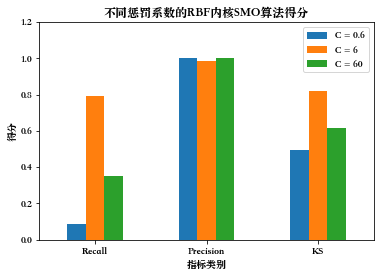

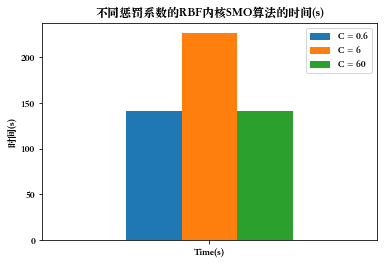

In [26]:
    dict2 = {"C = 0.6" : t[3]
         ,"C = 6" : t[4]
         ,"C = 60": t[5]
         }
    score_df2 = cmp_score(dict2, 2)